# TIMIT performance analysis
This analyzes model performance on the TIMIT corpus, with special attention to performance on vowels

In [1]:
from collections import Counter, defaultdict
from pathlib import Path

import ipatok
import kaldialign
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.color_palette("colorblind")
font = {"size": 16}
matplotlib.rc("font", **font)
# Remove the limits on the number of rows displayed in the notebook
pd.options.display.max_rows = None

In [2]:
GOLD_TRANSCRIPTIONS_CSV = Path("../../data/TIMIT Dataset/complete_ipa.csv")

TIMIT_EVAL_DIR = Path("../../data/timit_results/")
AGG_METRICS_CSV = TIMIT_EVAL_DIR / "aggregate_metrics" / "all_models_eval.csv"
DETAILED_PRED_DIR = TIMIT_EVAL_DIR / "detailed_predictions"
EDIT_DIST_DIR = TIMIT_EVAL_DIR / "edit_distances"

DIALECT_METRICS = Path("../timit_evaluation/Results/timit_dialect_model_comparison.csv")

TIMIT_VOWELS = ["ɑ", "æ", "ʌ", "ɔ", "ɛ", "ɪ", "i", "ʊ", "u", "ə", "ə̥", "ʉ", "ɨ", "ɹ̩", "ɚ"]
TIMIT_DIPHTHONGS = ["aʊ", "eɪ", "aɪ",  "oʊ", "ɔɪ"]

DIALECT_REGIONS = {
    "DR1": "DR1: New England",
    "DR2": "DR2: Northern",
    "DR3": "DR3: North Midland",
    "DR4": "DR4: South Midland",
    "DR5": "DR5: Southern",
    "DR6": "DR6: New York City",
    "DR7": "DR7: Western",
    "DR8": "DR8: Army Brat"
}


## Basic model performance comparisons
Show performance metrics for each model on TIMIT. 

In [3]:
# Manually define and join model source description
model_sources = [
    ("allosaurus_eng2102_eng", "Allosaurus English"),
    ("ginic/full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa", "Our AutoIPA: fine-tuned on full train split"),
    ("ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns", "Taguchi et al. 2023"),
    ("openai_whisper-large-v3-turbo_to_epitran", "Whisper + Epitran"),
    # Intentionally omitting Whisper medium - let's just keep the best in each category
    # ("openai_whisper-medium.en_to_epitran", "Whisper + Epitran"),
]

model_sources_df = pd.DataFrame(model_sources, columns=["model", "Model source"])


In [4]:
# Read in aggregate performance data
aggregate_perf_df = pd.read_csv(AGG_METRICS_CSV)
aggregate_perf_df = pd.merge(aggregate_perf_df, model_sources_df, on="model").sort_values(by="mean_phone_error_rate")

display(aggregate_perf_df)


,model,mean_phone_error_rate,mean_phone_feature_error_rate,mean_feature_error_rate,substitutions,insertions,deletions,Model source
1,ginic/full_dataset_train_3_wav2vec2-large-xlsr...,0.275325,3.420602,0.216646,43587,6700,7307,Our AutoIPA: fine-tuned on full train split
3,openai_whisper-large-v3-turbo_to_epitran,0.374312,4.463757,0.254656,59592,10681,7731,Whisper + Epitran
0,allosaurus_eng2102_eng,0.391094,4.481382,0.239781,62218,9569,9632,Allosaurus English
2,ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ip...,0.648082,6.092513,0.300393,104664,8546,22864,Taguchi et al. 2023


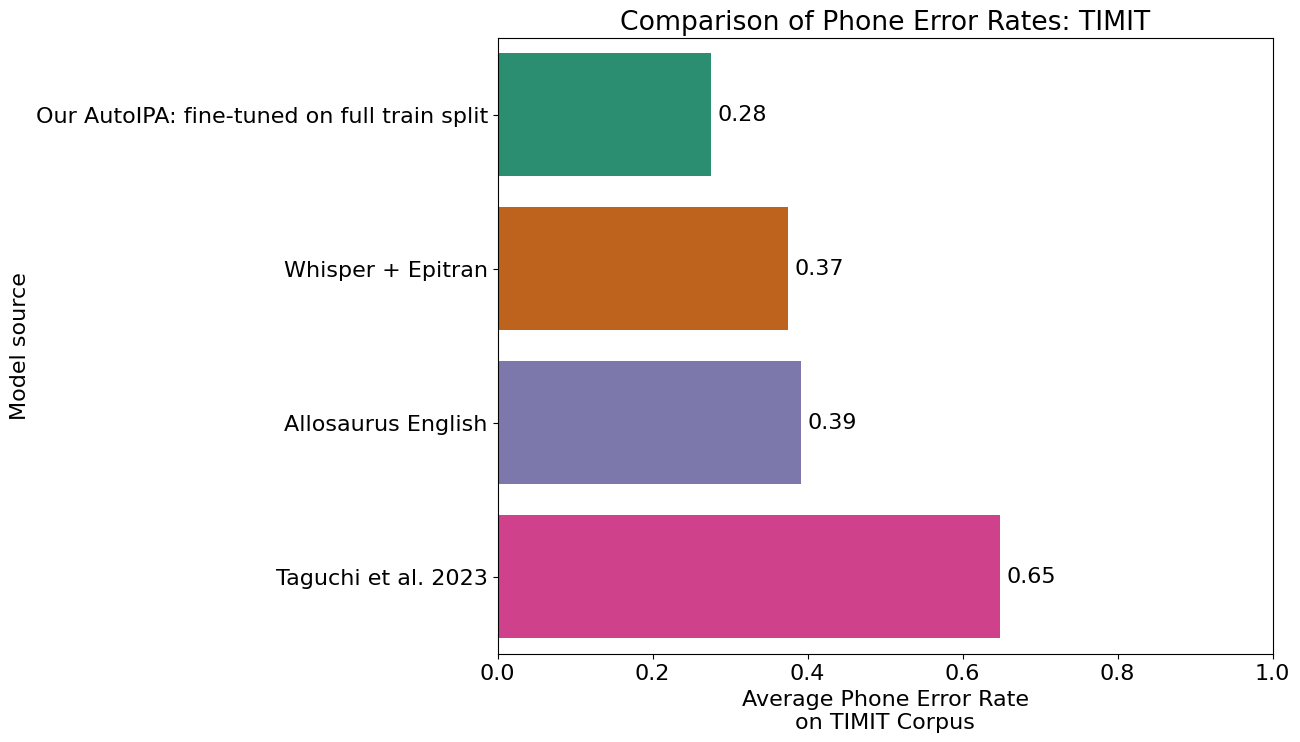

In [5]:
plt.figure(figsize=(10, 8))

g = sns.barplot(
    data=aggregate_perf_df, y="Model source", x="mean_phone_error_rate", hue="Model source", palette="Dark2"
)
g.set_title("Comparison of Phone Error Rates: TIMIT")
g.set_xlabel("Average Phone Error Rate\non TIMIT Corpus")
g.set_xlim((0,1))

for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)

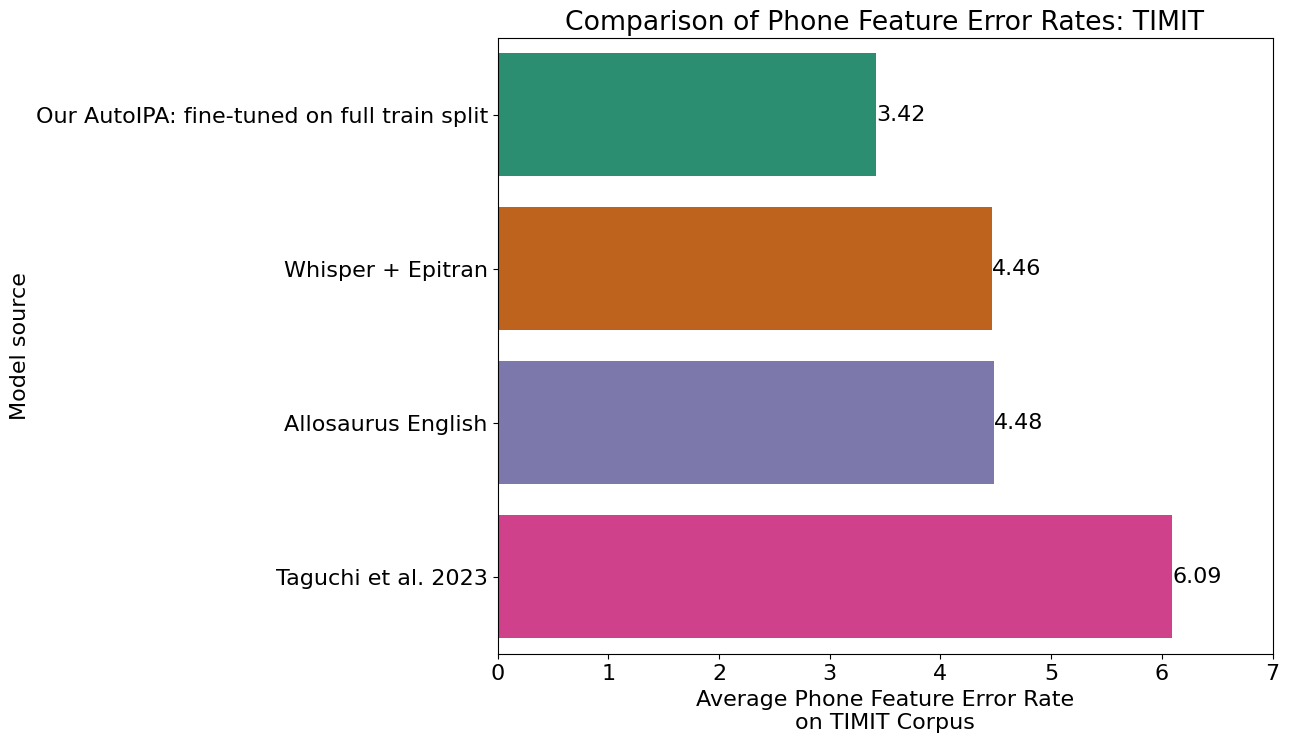

In [28]:
plt.figure(figsize=(10, 8))

g = sns.barplot(
    data=aggregate_perf_df, y="Model source", x="mean_phone_feature_error_rate", hue="Model source", palette="Dark2"
)
g.set_title("Comparison of Phone Feature Error Rates: TIMIT")
g.set_xlabel("Average Phone Feature Error Rate\non TIMIT Corpus")

g.set_xlim((0, 7))

for bar in g.containers:
    g.bar_label(bar, fmt="%.2f")


In [6]:
# Let's look specifically at substitution errors
substitution_dfs = []
for (model, _) in model_sources:
    file_prefix = model.replace("/", "_")
    edit_dist_path = EDIT_DIST_DIR / f"{file_prefix}_substitutions.csv"
    edit_dist_df = pd.read_csv(edit_dist_path)
    edit_dist_df["model"] = model
    substitution_dfs.append(edit_dist_df)

full_substitution_df = pd.concat(substitution_dfs)
print(full_substitution_df.shape)
display(full_substitution_df.head())

(5910, 4)


,original,substitution,total_substitutions,model
0,ɪ,j,6189,allosaurus_eng2102_eng
1,ɨ,ə,4515,allosaurus_eng2102_eng
2,ɨ,ɪ,3122,allosaurus_eng2102_eng
3,ʊ,w,2980,allosaurus_eng2102_eng
4,ɾ,t,2457,allosaurus_eng2102_eng


Text(0.5, 0, 'Total Substitution Errors\non TIMIT Corpus')

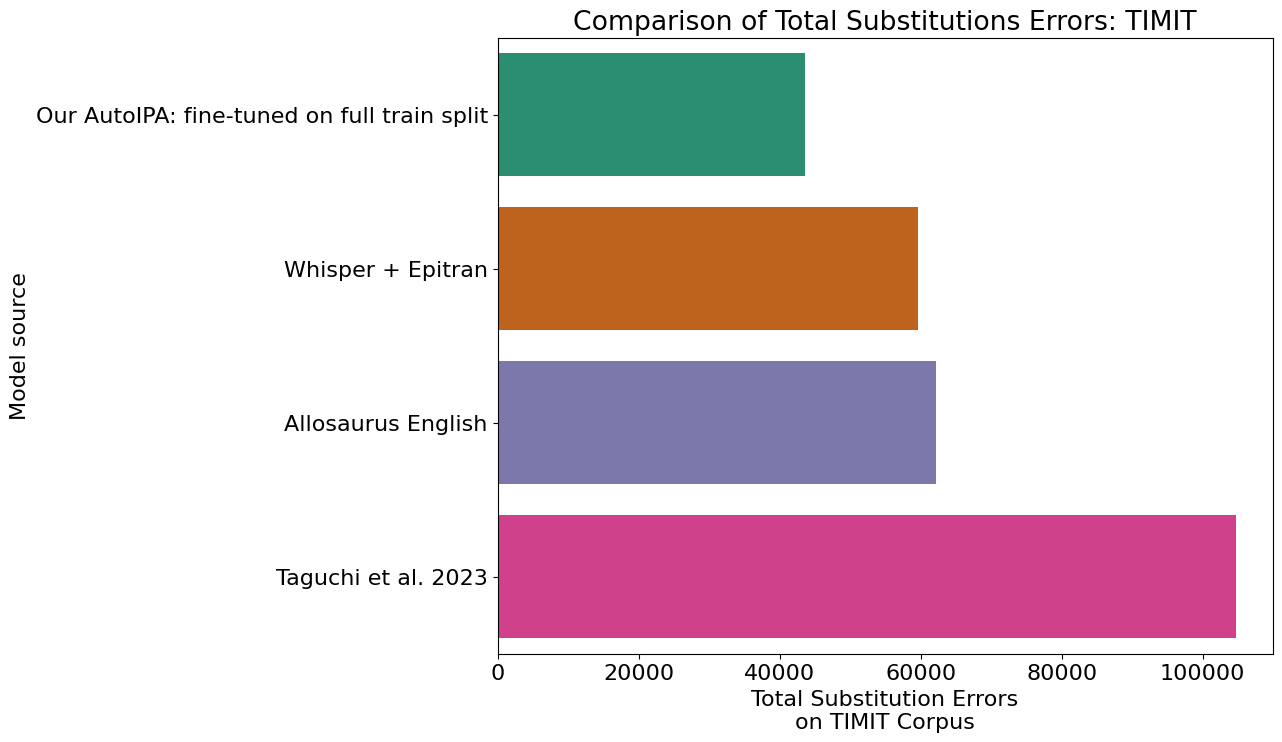

In [7]:
# Calculate total substitution errors for each model
subs_count_df = full_substitution_df.groupby("model")["total_substitutions"].sum().reset_index().sort_values(by="total_substitutions", ascending=True)
subs_count_df = pd.merge(subs_count_df, model_sources_df, on="model")
plt.figure(figsize=(10, 8))

g = sns.barplot(
    data=subs_count_df, y="Model source", x="total_substitutions", hue="Model source", palette="Dark2"
)
g.set_title("Comparison of Total Substitutions Errors: TIMIT")
g.set_xlabel("Total Substitution Errors\non TIMIT Corpus")

# Dialect Region Performance Plots
This creates bar charts showing performance by dialect. Since the groupby and averaging was already done, we just need to read in the data and plot the results.

In [8]:
# Show performance by dialect region
dialect_df = pd.read_csv(DIALECT_METRICS).merge(model_sources_df, on="model")
dialect_df = dialect_df.merge(pd.DataFrame(DIALECT_REGIONS.items(), columns=["dialect", "Dialect Region"]), on="dialect")
dialect_df =  dialect_df.sort_values(by=["Dialect Region", "phone_error_rates"], ascending=[True, True])
display(dialect_df)

,dialect,model,phone_error_rates,phone_feature_error_rates,feature_error_rates,Model source,Dialect Region
1,DR1,ginic/full_dataset_train_3_wav2vec2-large-xlsr...,0.280348,3.354082,0.211852,Our AutoIPA: fine-tuned on full train split,DR1: New England
3,DR1,openai_whisper-large-v3-turbo_to_epitran,0.386002,4.602041,0.256295,Whisper + Epitran,DR1: New England
0,DR1,allosaurus_eng2102_eng,0.401961,4.495918,0.237414,Allosaurus English,DR1: New England
2,DR1,ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ip...,0.645606,6.012245,0.298806,Taguchi et al. 2023,DR1: New England
5,DR2,ginic/full_dataset_train_3_wav2vec2-large-xlsr...,0.262502,3.380719,0.220450,Our AutoIPA: fine-tuned on full train split,DR2: Northern
7,DR2,openai_whisper-large-v3-turbo_to_epitran,0.365522,4.434559,0.256891,Whisper + Epitran,DR2: Northern
4,DR2,allosaurus_eng2102_eng,0.381017,4.410294,0.241293,Allosaurus English,DR2: Northern
6,DR2,ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ip...,0.638122,6.043137,0.299440,Taguchi et al. 2023,DR2: Northern
9,DR3,ginic/full_dataset_train_3_wav2vec2-large-xlsr...,0.264213,3.262051,0.213161,Our AutoIPA: fine-tuned on full train split,DR3: North Midland
11,DR3,openai_whisper-large-v3-turbo_to_epitran,0.370844,4.391095,0.256107,Whisper + Epitran,DR3: North Midland


Text(0.5, 1.05, "Models' Average Phone Error Rates by Dialect Region")

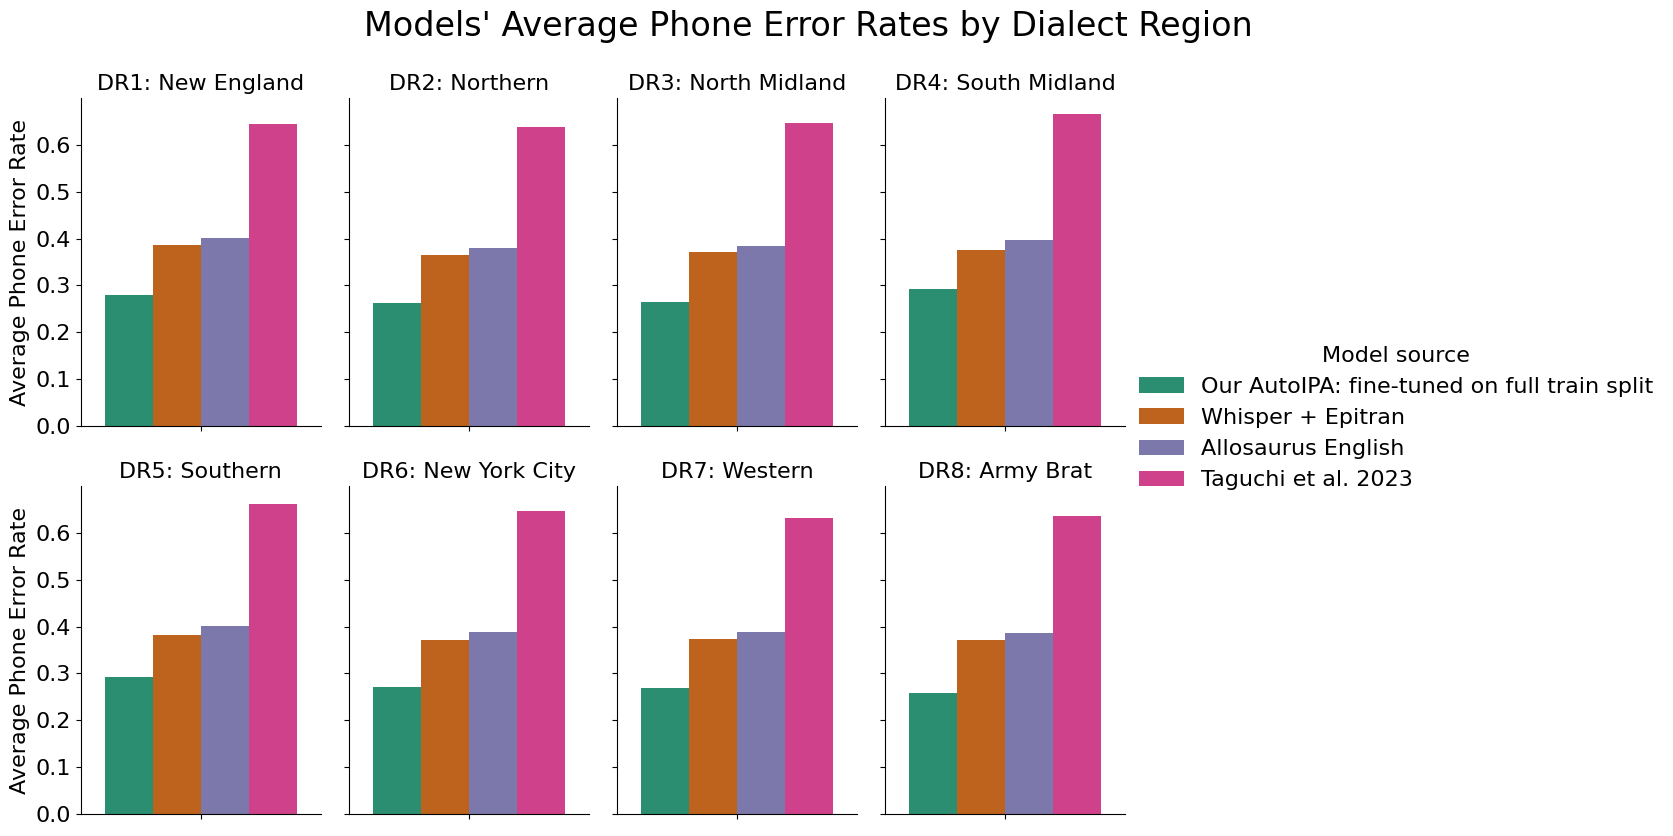

In [9]:
g = sns.FacetGrid(dialect_df, col="Dialect Region", col_wrap=4, height=4, aspect=0.75)
g.set_titles(col_template="{col_name}")
g.map_dataframe(sns.barplot, y="phone_error_rates", hue="Model source", palette="Dark2")
g.add_legend(title="Model source")
g.set_ylabels("Average Phone Error Rate")
g.fig.suptitle("Models' Average Phone Error Rates by Dialect Region", fontsize=24, y=1.05)


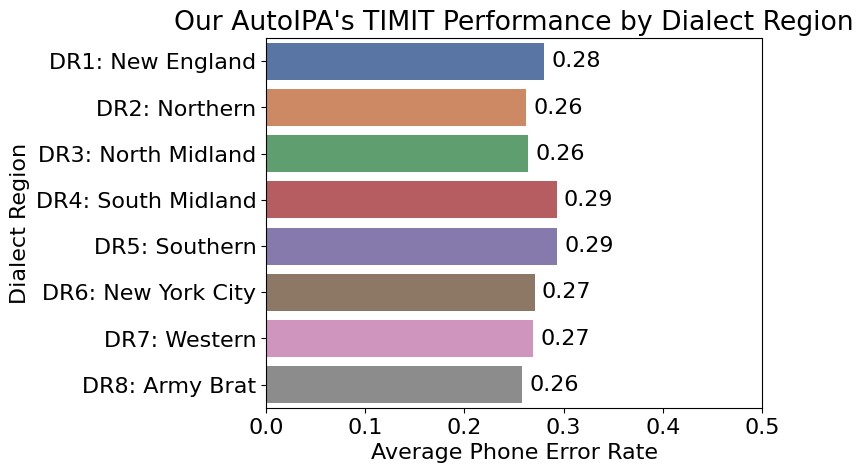

In [10]:
# Dialect performance for just our model
our_model_dialect_df = dialect_df[dialect_df["Model source"] == "Our AutoIPA: fine-tuned on full train split"]
g = sns.barplot(data=our_model_dialect_df, y="Dialect Region", x="phone_error_rates", hue="Dialect Region",palette="deep")
g.set_xlabel("Average Phone Error Rate")
g.set_xlim((0,0.5))
g.set(title="Our AutoIPA's TIMIT Performance by Dialect Region")
for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)


# Vowel Error Rate Analysis
How many instances of each vowel in the vocabulary are we getting wrong? 
$$ error\_rate(v) = \frac{count\_substitutions\_of(v) + count\_deletions(v)}{total\_count(v)}$$

In [11]:
gold_transcription_df = pd.read_csv(GOLD_TRANSCRIPTIONS_CSV)
gold_transcription_df["filename"] = gold_transcription_df["audio_filename"].str.lower()
gold_transcription_df["ipa_transcription"] = gold_transcription_df["ipa_transcription"].str.replace("ɝ", "ɹ̩")
vowel_counts = Counter()
for vowel in TIMIT_VOWELS + TIMIT_DIPHTHONGS:
    vowel_counts[vowel] += gold_transcription_df["ipa_transcription"].apply(lambda x: x.split().count(vowel)).sum()

vowel_counts

Counter({'ɨ': 11587,
         'i': 9663,
         'ɪ': 6760,
         'æ': 5404,
         'ɛ': 5293,
         'ə': 4956,
         'ɚ': 4790,
         'ɑ': 4197,
         'ɔ': 4096,
         'aɪ': 3242,
         'ʌ': 3185,
         'eɪ': 3088,
         'oʊ': 2913,
         'ɹ̩': 2846,
         'ʉ': 2488,
         'ɔɪ': 947,
         'aʊ': 945,
         'ʊ': 756,
         'u': 725,
         'ə̥': 493})

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_42358/978802300.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y=plot_vowels, x=plot_counts, palette="deep")


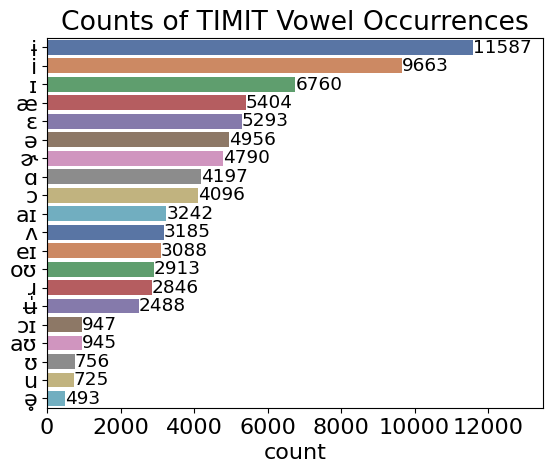

In [12]:
# Simple bar chart of vowel counts
plot_vowels, plot_counts = zip(*vowel_counts.most_common())
g = sns.barplot(y=plot_vowels, x=plot_counts, palette="deep")
g.set_xlim(0, 13500)
g.set_xlabel("count")
g.set(title="Counts of TIMIT Vowel Occurrences")
for bar in g.containers:
    g.bar_label(bar, fontsize='small')




In [13]:
EPS = "***"
def tally_edit_distance_errors(references, predictions):
    """Counts up edit distances from lists of already tokenized references and predictions."""
    subs = Counter()
    insertions = Counter()
    deletions = Counter()
    for ref_tokens, pred_tokens in zip(references, predictions):
        aligned_pairs = kaldialign.align(ref_tokens, pred_tokens, EPS)

        for r, p in aligned_pairs:
            if r == EPS:
                insertions[p] += 1
            elif p == EPS:
                deletions[r] += 1
            elif r != p:
                subs[(r, p)] += 1

    return subs, deletions, insertions

def diphthong_merge(t1, t2):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1+t2 in TIMIT_DIPHTHONGS:
        return True
    else:
        return False

In [14]:
# Re-do edit distance calculations with better tokenization, specifically turning
# on diphthong tokenization
our_model_detailed_preds_df = pd.read_csv(DETAILED_PRED_DIR / "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv").drop(columns=["substitutions", "insertions", "deletions"])
full_edit_distance_analysis_df = pd.merge(gold_transcription_df, our_model_detailed_preds_df, on="filename")

full_edit_distance_analysis_df["ipa_tokens"] = full_edit_distance_analysis_df["ipa_transcription"].str.split()
full_edit_distance_analysis_df["predicted_ipa_tokens"] = full_edit_distance_analysis_df["prediction"].apply(lambda x: ipatok.tokenise(x, diphthongs=True, merge=diphthong_merge))
print(full_edit_distance_analysis_df["ipa_tokens"][:10])
print(full_edit_distance_analysis_df["predicted_ipa_tokens"][:10])
display(full_edit_distance_analysis_df.head())


0    [ʃ, i, ɦ, æ, d, j, ɹ̩, d, ɑ, ɹ, k, s, u, ɾ, ɪ,...
1    [d, oʊ, n, æ, s, m, i, t, ɨ, k, ɛ, ɹ, i, ɨ, n,...
2    [h, ɪ, z, k, æ, p, t, ɨ, n, w, ə, s, θ, ɪ, n, ...
3    [ð, ɨ, ɹ, i, z, ə, n, z, f, ɚ, ð, ɪ, s, d, aɪ,...
4    [p, ɚ, d, ʌ, k, ʃ, ɨ, n, m, eɪ, f, ɔ, l, f, ɑ,...
5    [p, i, t, s, ɚ, ɹ, i, ɨ, z, ɑ, ɹ, k, ɨ, n, v, ...
6    [p, ʊ, t, ð, ə, b, ʊ, tʃ, ɚ, b, l, ɑ, k, t, eɪ...
7    [d, ɹ, ɑ, p, f, aɪ, v, f, ɔ, ɹ, m, z, ə, n, ð,...
8    [h, ɹ̩, w, ɔ, ɹ, d, ɹ, oʊ, b, k, n̩, s, ɪ, s, ...
9    [ʔ, ɛ, l, d, ɹ̩, l, i, p, i, p, l̩, ɹ̩, ɑ, f, ...
Name: ipa_tokens, dtype: object
0    [ʃ, i, h, æ, d, j, ɹ̩, d, ɑ, ɹ, k, s, u, ɾ, ɪ,...
1    [d, oʊ, n, d, æ, s, k, m, i, t, ɪ, k, æ, ɹ, i,...
2    [h, ɪ, z, k, æ, p, t, ʌ, n, w, ʊ, z, s, t, ɛ, ...
3    [ð, ʌ, ɹ, i, z, ʌ, n̩, z, f, ɹ̩, ð, ʌ, s, t, a...
4    [p, ɹ, ʌ, d, ʌ, k, ʃ, ʌ, n, m, eɪ, f, ɔ, l, f,...
5    [p, i, t, s, ʌ, ɹ, i, ɪ, z, ɑ, ɹ, k, ʌ, n, v, ...
6    [p, ʊ, t, ð, ʌ, b, ʊ, t, ʃ, ɹ̩, b, l, ɑ, k, t,...
7    [d, ɹ, ɑ, p, f, aɪ, v, f, ɔ,

,audio_filename,ipa_transcription,filename,ipa,prediction,phone_error_rates,phone_feature_error_rates,feature_error_rates,ipa_tokens,predicted_ipa_tokens
0,/COMPLETE/DR1/FAKS0/SA1.wav,ʃ i ɦ æ d j ɹ̩ d ɑ ɹ k s u ɾ ɪ ŋ g ɹ i s i w ...,/complete/dr1/faks0/sa1.wav,ʃiɦædjɹ̩dɑɹksuɾɪŋgɹisiwɑʃwɑɾɹ̩ʔɔljiɚ,ʃihædjɹ̩dɑɹksuɾɪnɡɹisiwɑʃwɔɾɹ̩ɔljiɹ,0.187500,2.666667,0.075521,"[ʃ, i, ɦ, æ, d, j, ɹ̩, d, ɑ, ɹ, k, s, u, ɾ, ɪ,...","[ʃ, i, h, æ, d, j, ɹ̩, d, ɑ, ɹ, k, s, u, ɾ, ɪ,..."
1,/COMPLETE/DR1/FAKS0/SA2.wav,d oʊ n æ s m i t ɨ k ɛ ɹ i ɨ n ɔɪ l i ɹ æ g ...,/complete/dr1/faks0/sa2.wav,doʊnæsmitɨkɛɹiɨnɔɪliɹæglaɪkðæt,doʊndæskmitɪkæɹiɪnɔɪliɹæɡlaɪkðæʔ,0.241379,3.500000,0.227730,"[d, oʊ, n, æ, s, m, i, t, ɨ, k, ɛ, ɹ, i, ɨ, n,...","[d, oʊ, n, d, æ, s, k, m, i, t, ɪ, k, æ, ɹ, i,..."
2,/COMPLETE/DR1/FAKS0/SI1573.wav,h ɪ z k æ p t ɨ n w ə s θ ɪ n æ n ɦ æ g ɹ̩ d ...,/complete/dr1/faks0/si1573.wav,hɪzkæptɨnwəsθɪnænɦægɹ̩dɨnɪzbjʉɾʉfl̩butswɚwɔɹnɨ...,hɪzkæptʌnwʊzstɛnʌnhæɡɹ̩dɛnɪzbjuɾʌfl̩butswɹ̩wɔɹ...,0.297872,4.916667,0.311170,"[h, ɪ, z, k, æ, p, t, ɨ, n, w, ə, s, θ, ɪ, n, ...","[h, ɪ, z, k, æ, p, t, ʌ, n, w, ʊ, z, s, t, ɛ, ..."
3,/COMPLETE/DR1/FAKS0/SI2203.wav,ð ɨ ɹ i z ə n z f ɚ ð ɪ s d aɪ v s i m d f u ...,/complete/dr1/faks0/si2203.wav,ðɨɹizənzfɚðɪsdaɪvsimdfulɨʃnaʊ,ðʌɹizʌn̩zfɹ̩ðʌstaɪvsimdfulʌʃnaʊ,0.250000,1.333333,0.282738,"[ð, ɨ, ɹ, i, z, ə, n, z, f, ɚ, ð, ɪ, s, d, aɪ,...","[ð, ʌ, ɹ, i, z, ʌ, n̩, z, f, ɹ̩, ð, ʌ, s, t, a..."
4,/COMPLETE/DR1/FAKS0/SI943.wav,p ɚ d ʌ k ʃ ɨ n m eɪ f ɔ l f ɑ ɹ b ə l oʊ ə k...,/complete/dr1/faks0/si943.wav,pɚdʌkʃɨnmeɪfɔlfɑɹbəloʊəkspɨkteɪʃn̩ts,pɹʌdʌkʃʌnmeɪfɔlfɑɹbl̩loʊɛkspɛkteɪʃʌns,0.235294,2.958333,0.331495,"[p, ɚ, d, ʌ, k, ʃ, ɨ, n, m, eɪ, f, ɔ, l, f, ɑ,...","[p, ɹ, ʌ, d, ʌ, k, ʃ, ʌ, n, m, eɪ, f, ɔ, l, f,..."


In [15]:
sub_counter, del_counter, inserts_counter = tally_edit_distance_errors(full_edit_distance_analysis_df["ipa_tokens"], full_edit_distance_analysis_df["predicted_ipa_tokens"])


In [16]:
# Get subs and deletions in good format for analysis
detailed_error_counts = defaultdict(Counter)
subs_counts = Counter()
for (sub_tuple, count) in sub_counter.items():
    subs_counts[sub_tuple[0]] += count
    detailed_error_counts[sub_tuple[0]][sub_tuple[1]] += count

print("Substitution Counts:", subs_counts)

for (deleted, count) in del_counter.items():
    detailed_error_counts[deleted]["<deleted>"] += count

print("Detailed Error Counts:", detailed_error_counts)

Substitution Counts: Counter({'ɨ': 10915, 'ɚ': 4719, 'ə': 4566, 'g': 2950, 'ʉ': 2468, 'ɪ': 1900, 'dʒ': 1554, 'ɦ': 1481, 'ʔ': 1442, 't': 1308, 'tʃ': 1073, 'ɔ': 905, 'z': 890, 'i': 839, 'ɛ': 619, 'ɹ̩': 614, 'l̩': 587, 'ɾ̃': 510, 'n̩': 437, 'd': 432, 'aɪ': 409, 'ə̥': 383, 'n': 377, 'æ': 374, 'ð': 369, 'ɑ': 345, 'ɾ': 284, 'oʊ': 280, 'ɔɪ': 271, 'ʌ': 266, 'ʊ': 263, 'eɪ': 219, 'ɹ': 213, 'v': 167, 's': 140, 'ŋ': 137, 'l': 129, 'dH': 116, 'aʊ': 109, 'j': 107, 'm̩': 105, 'p': 104, 'θ': 97, 'b': 96, 'm': 75, 'w': 72, 'ʃ': 62, 'ʒ': 53, 'k': 52, 'u': 45, 'ŋ̍': 43, 'h': 40, 'f': 26, 'tH': 14, 'ɡ': 2})
Detailed Error Counts: defaultdict(<class 'collections.Counter'>, {'ɦ': Counter({'h': 1409, '<deleted>': 42, 'ʌ': 14, 'ɪ': 8, 'ɾ': 7, 'l': 5, 'ɹ̩': 5, 'ʒ': 4, 'ɛ': 3, 'ɹ': 3, 'ɑ': 3, 'i': 2, 'd': 2, 'k': 2, 'æ': 2, 'eɪ': 2, 'u': 2, 'ɾ̃': 1, 'v': 1, 's': 1, 'n̩': 1, 'z': 1, 'ŋ': 1, 'ʃ': 1, 'n': 1}), 'ŋ': Counter({'n': 102, 'ɡ': 17, '<deleted>': 11, 'm': 3, 'ʌ': 2, 'ɾ̃': 2, 'k': 2, 'ɛ': 2, 'n̩': 1, 'ɑ': 

In [17]:
# Compute vowel error rates
vowel_error_rates = {}
for v in TIMIT_VOWELS + TIMIT_DIPHTHONGS:
    subs_count = subs_counts[v]
    dels_count = del_counter[v]
    ver = (subs_count + dels_count)/ (vowel_counts[v])
    vowel_error_rates[v] = ver

ver_df = pd.DataFrame(vowel_error_rates.items(), columns=["Vowel", "Vowel Error Rate"]). sort_values(by="Vowel Error Rate", ascending=False)
error_ordering = ver_df[ver_df["Vowel Error Rate"] > 0]["Vowel"].tolist()
print("In descending frequency of errors:", error_ordering)

display(ver_df)


In descending frequency of errors: ['ə̥', 'ɚ', 'ɨ', 'ʉ', 'ə', 'ʊ', 'ɔɪ', 'ɪ', 'ɔ', 'ɹ̩', 'aɪ', 'ɛ', 'aʊ', 'oʊ', 'ɑ', 'i', 'ʌ', 'eɪ', 'æ', 'u']


,Vowel,Vowel Error Rate
10,ə̥,1.000000
14,ɚ,1.000000
12,ɨ,1.000000
11,ʉ,1.000000
9,ə,1.000000
7,ʊ,0.355820
19,ɔɪ,0.354805
5,ɪ,0.297633
3,ɔ,0.249023
13,ɹ̩,0.218904


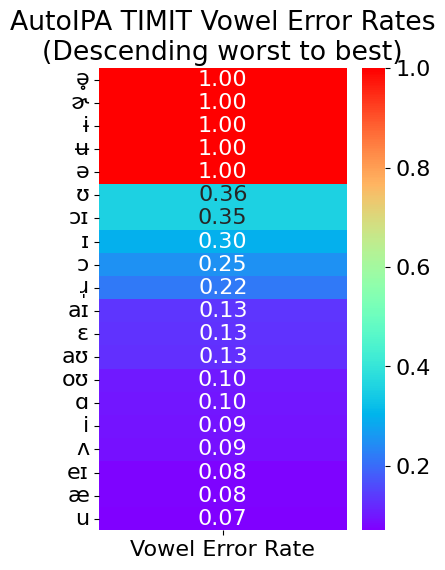

In [18]:
plt.figure(figsize=(4, 6))
sns.heatmap(
    ver_df.sort_values(by="Vowel Error Rate", ascending=False).set_index("Vowel"),
    cmap="rainbow",
    # cmap="spring_r",
    annot=True,
    fmt=".2f",
    yticklabels=True,
    # linewidths=1,
)
plt.title("AutoIPA TIMIT Vowel Error Rates\n(Descending worst to best)")
# plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("")
plt.show()


In [19]:
interesting_vowels = ver_df[ver_df["Vowel Error Rate"] > 0.0]["Vowel"].tolist()
print(interesting_vowels)


interesting_errors = []
for v in interesting_vowels:
    for error, count in detailed_error_counts[v].items():
        interesting_errors.append((v, error, count))

interesting_errors_df = pd.DataFrame(interesting_errors, columns=["Vowel", "Error", "Count"])
interesting_errors_df["Ratio of Vowel's Errors"] = interesting_errors_df.groupby("Vowel", group_keys=False)["Count"].apply(lambda x: x / x.sum())
display(interesting_errors_df)


['ə̥', 'ɚ', 'ɨ', 'ʉ', 'ə', 'ʊ', 'ɔɪ', 'ɪ', 'ɔ', 'ɹ̩', 'aɪ', 'ɛ', 'aʊ', 'oʊ', 'ɑ', 'i', 'ʌ', 'eɪ', 'æ', 'u']


,Vowel,Error,Count,Ratio of Vowel's Errors
0,ə̥,ɛ,6,0.012170
1,ə̥,ʌ,143,0.290061
2,ə̥,u,15,0.030426
3,ə̥,ɪ,97,0.196755
4,ə̥,ʊ,3,0.006085
5,ə̥,t,32,0.064909
6,ə̥,s,3,0.006085
7,ə̥,ʃ,10,0.020284
8,ə̥,i,12,0.024341
9,ə̥,w,1,0.002028


In [20]:
# Grab top ten errors for each vowel
top_errors_df = interesting_errors_df.groupby("Vowel").apply(lambda x: x.nlargest(5, "Count")).reset_index(drop=True)
top_errors_df["Vowel"] = pd.Categorical(top_errors_df["Vowel"], categories=error_ordering, ordered=True)
top_errors_df = top_errors_df.sort_values(by=["Vowel", "Count"], ascending=[True, False])
display(top_errors_df.head(20))

,Vowel,Error,Count,Ratio of Vowel's Errors
55,ə̥,ʌ,143,0.290061
56,ə̥,<deleted>,110,0.223124
57,ə̥,ɪ,97,0.196755
58,ə̥,t,32,0.064909
59,ə̥,ʒ,30,0.060852
60,ɚ,ɹ̩,2995,0.625261
61,ɚ,ɹ,927,0.193528
62,ɚ,ʌ,214,0.044676
63,ɚ,d,108,0.022547
64,ɚ,ʒ,102,0.021294


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_42358/1151548004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  convention_errors_df["Vowel"] = pd.Categorical(convention_errors_df["Vowel"], categories=convention_errors, ordered=True)


Text(0.5, 1.05, 'Top 5 errors for vowels AutoIPA always incorrectly transcribes')

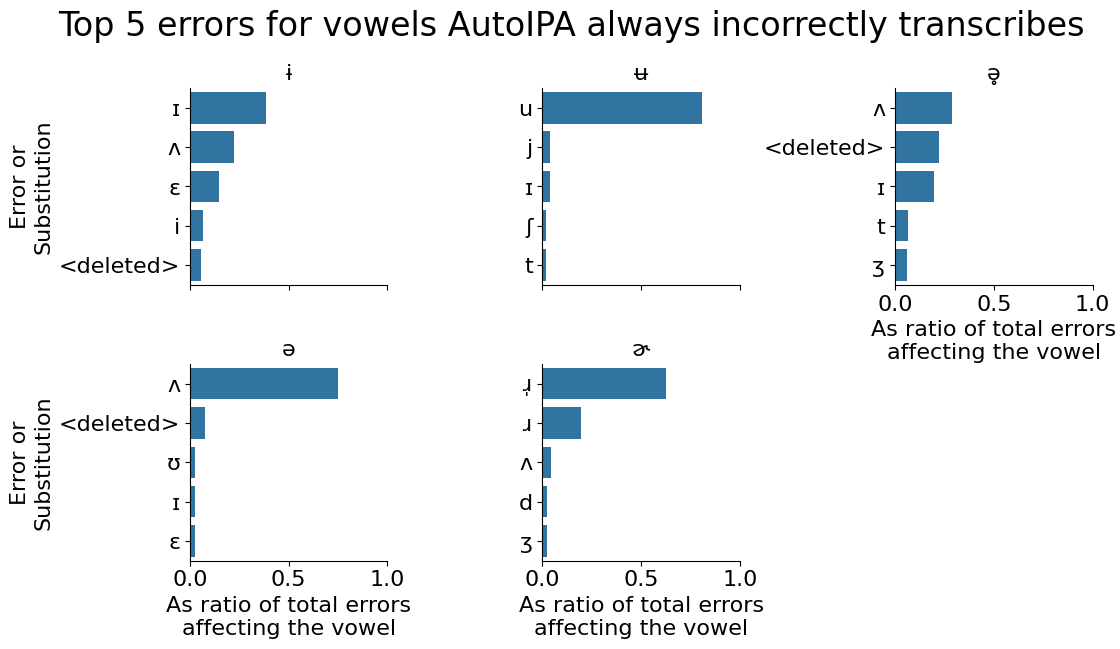

In [21]:
convention_errors = ["ɨ", "ʉ", "ə̥", "ə", "ɚ"]

convention_errors_df = top_errors_df[top_errors_df["Vowel"].isin(convention_errors)]
convention_errors_df["Vowel"] = pd.Categorical(convention_errors_df["Vowel"], categories=convention_errors, ordered=True)
g = sns.FacetGrid(convention_errors_df, col="Vowel", col_wrap=3, sharey=False, xlim=(0, 1), aspect=1.25)
g.map_dataframe(sns.barplot, x="Ratio of Vowel's Errors", y="Error", orient="h")
g.set_titles(col_template="{col_name}")
g.set_ylabels("Error or\nSubstitution")
g.set_xlabels("As ratio of total errors\naffecting the vowel")
g.fig.suptitle("Top 5 errors for vowels AutoIPA always incorrectly transcribes", fontsize=24, y=1.05)


['ʊ', 'ɔɪ', 'ɪ', 'ɔ', 'ɹ̩', 'aɪ', 'ɛ', 'aʊ', 'oʊ', 'ɑ', 'i', 'ʌ', 'eɪ', 'æ', 'u']


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_42358/3716590903.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_convention_errors_df["Vowel"] = pd.Categorical(


,Vowel,Error,Count,Ratio of Vowel's Errors
90,ʊ,ʌ,133,0.494424
91,ʊ,u,23,0.085502
92,ʊ,ɪ,15,0.055762
93,ʊ,oʊ,15,0.055762
94,ʊ,ɔ,15,0.055762
45,ɔɪ,ɔ,90,0.267857
46,ɔɪ,oʊ,74,0.220238
47,ɔɪ,<deleted>,65,0.193452
48,ɔɪ,ɹ,34,0.101190
49,ɔɪ,ʌ,27,0.080357


Text(0.5, 1.05, 'Remaining TIMIT Vowels: Top 5 AutoIPA Errors for each vowel')

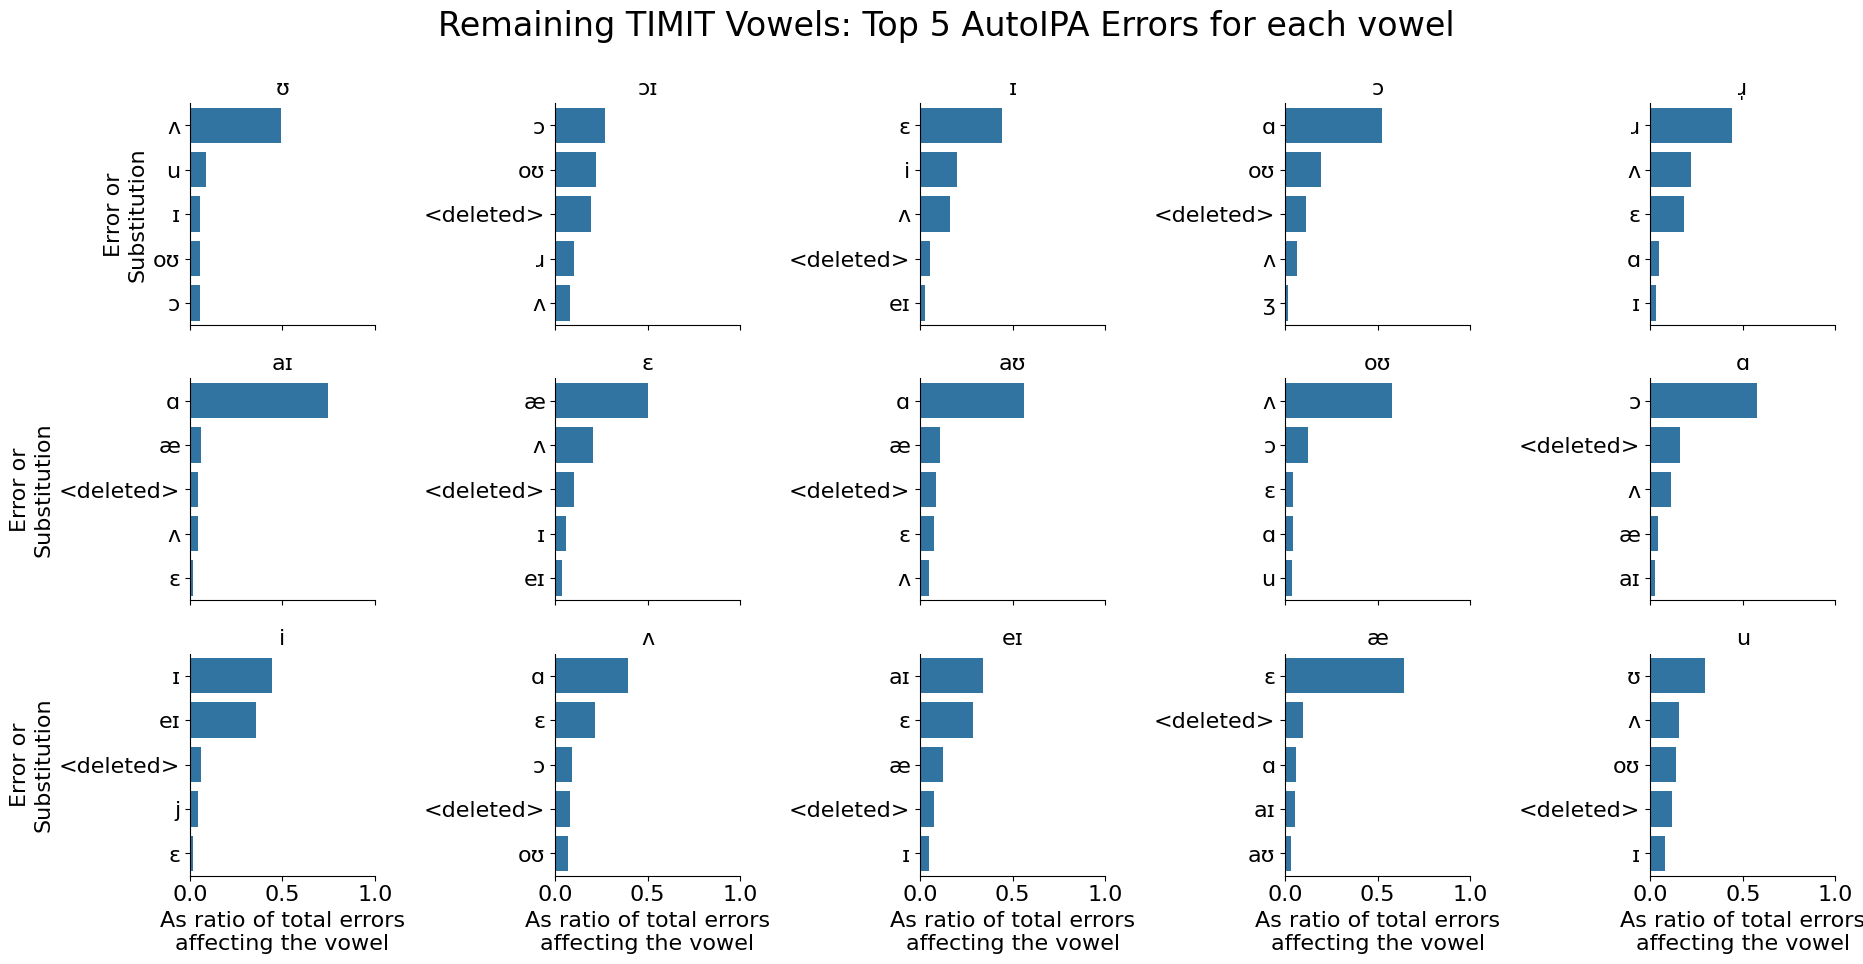

In [22]:
not_convention_errors = [v for v in interesting_vowels if v not in convention_errors]
print(not_convention_errors)
not_convention_errors_df = top_errors_df[top_errors_df["Vowel"].isin(not_convention_errors)]
not_convention_errors_df["Vowel"] = pd.Categorical(
not_convention_errors_df["Vowel"], categories=not_convention_errors, ordered=True
)
display(not_convention_errors_df.head(20))

g = sns.FacetGrid(not_convention_errors_df, col="Vowel", col_wrap=5, sharey=False, aspect=1.25, xlim=(0, 1))
g.map_dataframe(sns.barplot, x="Ratio of Vowel's Errors", y="Error", orient="h")
g.set_titles(col_template="{col_name}", fontsize=20)
g.set_ylabels("Error or\nSubstitution")
g.set_xlabels("As ratio of total errors\naffecting the vowel")
g.fig.suptitle("Remaining TIMIT Vowels: Top 5 AutoIPA Errors for each vowel", fontsize=24, y=1.05)